# Bayesian Linear Regression

This notebook provides a 

## Regression

The goal of regression is to predict the value of one or more continuous target variables $y$ given the value of a $D$-dimensional vector $x$ of input variables. More specifically, given a training data set of $N$ observations $\mathbf{X} = \{x_n\}$, where $n = 1,...,N$, together with corresponding target values $\mathbf{Y} = \{y_n\}$, the task of regression is to predict the value of $y$ for a new value of $x$. The target and observed variates are related through a mapping,

$$f : X \rightarrow Y$$

where $f$ indicates the mapping. In a probabilistic setting we need to consider the uncertainty in both our observations and the mapping $f$. The likelihood function expresses how probable the observed data set is for different settings of the parameter vector $\mathbf{w}$. Starting with the relationship between two single input $x_n$ and output $y_n$ points, we can assume a Gaussian likelihood of the form,

$$p(\mathbf{y}_n|f, \mathbf{x}_n) \sim \mathcal{N}(f(\mathbf{x}_n)|\sigma^2 \mathbf{I}) $$

//TODO:?ADD ASSUMPTIONS OF GAUSSIAN LIKELIHOOD??

Assuming each output point is independent given the input point and the mapping $f$, the likelihood can be written in factorised form,

$$p(\mathbf{Y}|f, \mathbf{X}) = \prod\limits_{n=1}^{N} p(\mathbf{y}_n|f, \mathbf{x}_n).$$

In regression, we seek to infer a continuous $\mathbf{y}_n$ from it's corresponding variate $\mathbf{x_n}$. Taking uncertainty into account, we want to reach the posterior distribution over the mapping given the observations,

$$p(f|\mathbf{X}, \mathbf{Y}).$$

## Linear Regression

In linear regression we make the assumption that the mapping between observed and target variates is linear. Here, we further make assumptions about the structure of the noise in our observed data, that it has been corrupted by additive Gaussian noise,

$$\mathbf{y}_n = \mathbf{W} \mathbf{x}_n + \epsilon,$$

where $\epsilon \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$. The likelihood then takes the form,

$$p(\mathbf{Y} | \mathbf{W}, \mathbf{X}) = \prod\limits_{n=1}^{N} p(\mathbf{y}_n|\mathbf{w}^T \mathbf{x}_n, \sigma^2 \mathbf{I})$$


Note: A Bayesian treatment of linear regression avoids the over-fitting problem of maximum likelihood and leads to automatic methods of determining model complexity using the training data alone.


In [1]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from numpy.linalg import inv
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

We want to show that the approach described above is capable of recovering the true underlying mapping from observed data. In order to test this we first generate some data and then simply throw away the generating parameters.

In [30]:
# create observations
x = np.ones([201, 2])
x[:, 0] = np.linspace(-1, 1, 201)

mu = 0  # mean of observation noise
sigma = 0.3  # variance of observation noise
W = np.array([[-1.3, 0.5]]) # weight parameters [W0 W1]

# generate target data using observations x, weight parameters W and observation noise N(mu, sigma)
y = x @ W.T + np.random.normal(mu, sigma, x[:, 0:1].shape)

Lets display the data so that we know what we are trying to recover.

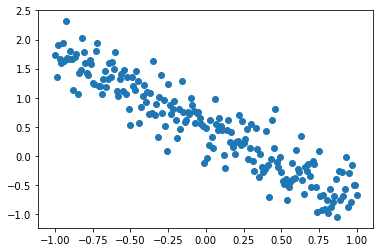

In [31]:
plt.scatter(x[:, 0:1], y[:, 0:1])

We begin our Bayesian treatment of the linear regression problem by introducing a prior probability distribution over the model parameters **W**

In [32]:
t = 0.5
prior_var = t * np.eye(W.shape[1])
prior_w = multivariate_normal(mean=W.flatten(), cov=prior_var)

In [33]:
def plot_over_w(dist, title):
    w0, w1 = np.mgrid[-3:1:.01, -1:3:.01]
    pos = np.empty([w0.shape[0], w0.shape[0], 2])
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1
    f = plt.figure()
    cp = plt.contourf(w0, w1, dist.pdf(pos))
    plt.xlabel('$w_0$', fontsize=16)
    plt.ylabel('$w_1$', fontsize=16)
    plt.title(title, fontsize=16)

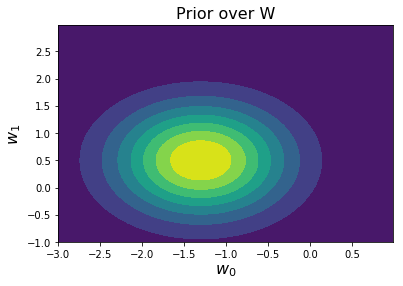

In [34]:
plot_over_w(prior_w, 'Prior over W')

In [35]:
# create Y
Y=y
print(x.shape)
print(Y.shape)

(201, 2)
(201, 1)


In [72]:
# def posterior(x, Y, N):
#     ########################################################################################
#     # posterior - Calculates posterior over w from N input data points (x,Y)
#     #   Inputs:
#     #       x -> training input data
#     #       Y -> trianing target data
#     #       N -> number of input data points
#     #   Outputs:
#     #      w0 -> weight parameter W0 sampled from posterior for N input data points
#     #      w1 -> weight parameter W1 sampled from posterior for N input data points
#     #       x[:,1] -> training input data for N data points
#     #       Y -> training target data for N data points
#     #       posterior_w -> the posterior distribution over w for N input data points
#     ########################################################################################
#     x = x[:N-1, :]
#     Y = Y[:N-1, :]
#     m_n = 1 / (sigma) * (inv(1 / (sigma) * x.T.dot(x) + t * np.identity(x.shape[1]))).dot(x.T).dot(Y)
#     s_n_inv = 1/(sigma) * (x.T).dot(x) + t*np.identity(x.shape[1])
#     s_n = inv(s_n_inv)
#     posterior_w = multivariate_normal(m_n.flatten(),cov=[[s_n.item(0),s_n.item(1)],[s_n.item(2),s_n.item(3)]])

#     # calculate posterior for N data points
#     if N > x.shape[1]:
#         N = x.shape[1]
#     elif N < 1:
#         N = 1

#     w0, w1 = np.random.multivariate_normal(m_n.flatten(),cov=[[s_n.item(0),s_n.item(1)],[s_n.item(2),s_n.item(3)]])

#     return w0, w1, x[:, 0], Y, posterior_w
# def posterior(x, Y):

#     m_n = 1 / (sigma) * (inv(1 / (sigma) * x.T.dot(x) + t * np.identity(x.shape[1]))).dot(x.T).dot(Y)
#     s_n_inv = 1/(sigma) * (x.T).dot(x) + t*np.identity(x.shape[1])
#     s_n = inv(s_n_inv)
#     posterior_w = multivariate_normal(m_n.flatten(),cov=[[s_n.item(0),s_n.item(1)],[s_n.item(2),s_n.item(3)]])

#     # calculate posterior
#     w0, w1 = np.random.multivariate_normal(m_n.flatten(),cov=[[s_n.item(0),s_n.item(1)],[s_n.item(2),s_n.item(3)]])

#     return w0, w1, x[:, 0], Y, posterior_w
def posterior(x, Y):
    m_n = 1 / (sigma) * (inv(1 / (sigma) * x.T.dot(x) + t * np.identity(x.shape[1]))).dot(x.T).dot(Y)
    s_n_inv = 1/(sigma) * (x.T).dot(x) + t*np.identity(x.shape[1])
    s_n = inv(s_n_inv)
    return multivariate_normal(m_n.flatten(),cov=[[s_n.item(0),s_n.item(1)],[s_n.item(2),s_n.item(3)]])

In [89]:
def plot_lines(x, Y, i):
    plt.figure()
    lines[:, i] = w0 * x[:i-1, 1] + w1
    print(lines)
#     plt.plot(x[:, 1], lines[:, i-5:i], 'r')
    plt.plot(x[:i-1, 0], Y[:i-1], marker='o', linestyle='none', color='b')
    plt.xlabel('$x$',fontsize=16)
    plt.ylabel('$y$',fontsize=16)
    plt.title('Data space (%d data points)' % i, fontsize=16)

In [94]:
# x = np.ones([201,2])
# x[:,1] = np.linspace(-1,1,201)
# plot data space
N = 201 # number of lines
lines = np.zeros([N, x.shape[0]])
print(x.shape)
for i in range(0,N):

    # calculate posterior for i data points
    posterior_w = posterior(x[:i-1], Y[:i-1])
#     lines[:, i] = w0 * x[:, 0] + w1

    # create figures for 10, 50 and 100 data points showing input data and the fits for N-5 to N data point
    if i == 10 or i == 50 or i ==200:
        plot_lines(x, Y, i)
        # plot posterior over w for N data points
        plot_over_w(posterior_w, 'Posterior (%d data points)' % i)

(201, 2)


ValueError: could not broadcast input array from shape (9) into shape (201)

<Figure size 432x288 with 0 Axes>

In [93]:
print((x[0:i-1, 1]).shape)

(9,)


(201, 201)


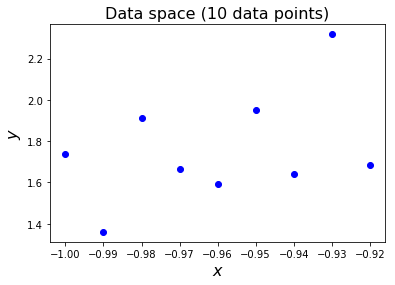

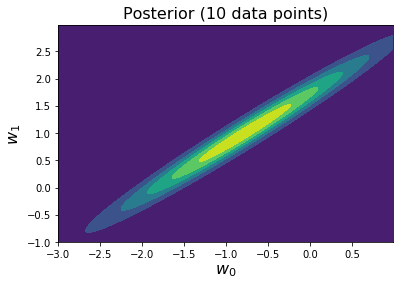

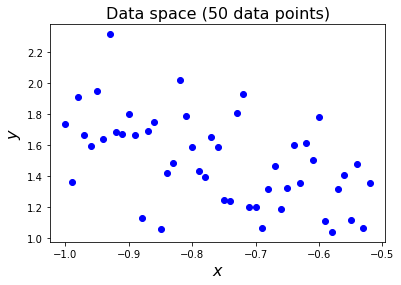

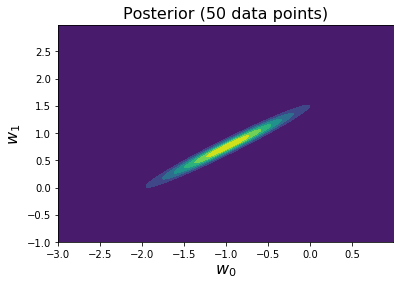

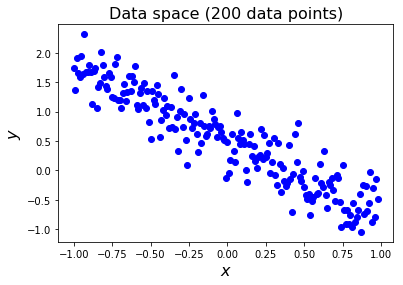

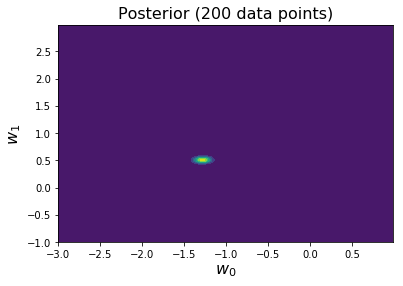

In [57]:
# x = np.ones([201,2])
# x[:,1] = np.linspace(-1,1,201)
# plot data space
N = 201 # number of lines
lines = np.zeros([N, x.shape[0]])
print(lines.shape)
for i in range(0,N):

    # calculate posterior for i data points
    w0, w1, x1, Y1, posterior_w = posterior(x[:i], Y[:i], i)
#     lines[:, i] = w0 * x[:, 0] + w1

    # create figures for 10, 50 and 100 data points showing input data and the fits for N-5 to N data point
    if i == 10 or i == 50 or i ==200:
        plot_lines(x, i, x1, Y1)
        # plot posterior over w for N data points
        plot_over_w(posterior_w, 'Posterior (%d data points)' % i)

In [ ]:
## Bayes Rule
Bayes’ theorem can be used to convert a prior probability into a posterior probability by incorporating the evidence provided by the observed data. We can capture our assumptions about the model parameters $\mathbf{w}$, before observing the data, in the form of a prior probability distribution $p(\mathbf{w})$. The effect of the observed data $D$ is expressed through the conditional probability $p(D|\mathbf{w})$. Baye's theorem then takes the form,

$$p(\mathbf{w}|D) = \frac{p(D|\mathbf{w})p(\mathbf{w})}{p(D)}$$

enabling us to evaluate the uncertainty in $\mathbf{w}$ after we have observed $D$ in the form of the posterior probability $p(\mathbf{w}|D)$.